In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# running IBM Quantum computer
from qiskit.tools.monitor import job_monitor
import random as rand

        

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def select_backend(backend_type):
    if backend_type == 'simulator' : 
        return BasicAer.get_backend('qasm_simulator')
    else: 
        provider = IBMQ.get_provider(hub='ibm-q')
           
        return least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (1) and
                                           not x.configuration().simulator and x.status().operational==True))

In [4]:
def handle_job(job, backend_type):
    results = job.result().to_dict()['results']
    result = np.array(list(map(lambda x: x[-1], np.concatenate([r['data']['memory'] for r in results]).flat)))
    return result
    

In [5]:
def bin_list_2_pts(bin_list):
    bin_int64_list = [''.join(bin_list[i:i+64]) for i in range(0,len(bin_list), 64)]
    int_list = list(map(lambda x: int(x,2)/(2**64-1) , bin_int64_list))
    pts = [(int_list[i], int_list[i + 1]) for i in range(0, len(int_list), 2)]
    return pts

In [6]:
def gen_pts(comp_type, backend_type): 
    if comp_type.lower() == 'classical':
        return np.array([(rand.random(), rand.random()) for _ in range(50)])
    else: 
        # Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
        qc = QuantumCircuit(1,1)
        qc.h(0)
        qc.measure(0,0)
        
        rnd_circuit = [qc for _ in range(50)]
        backend = select_backend(backend_type)
        print("least busy backend: ", backend)
        shots = 8192
        job = execute(rnd_circuit, backend=backend, shots=shots, optimization_level=3, memory=True)
        job_monitor(job, interval = 2)
        
      
        
        bin_list = handle_job(job, backend_type)
        pts = bin_list_2_pts(bin_list)
        return np.array(pts)
    

In [7]:
def in_circle(pt): 
    result = pt[0]*pt[0] + pt[1] * pt[1]
    return 1 if result <= 1 else 0

In [23]:
def calculate_pi(number_of_digits, comp_type, backend_type='simulator'):
    pi = 0
    pts = list(map(in_circle,  gen_pts(comp_type, backend_type)))
    pts_in_square = 0 
    pts_in_circle = 0
    pi_list = []
    while round(pi, number_of_digits - 1) != round(np.pi, number_of_digits - 1):
        for pt in pts: 
            pts_in_square += 1
            pts_in_circle += pt
            
            pi = 4 * pts_in_circle / pts_in_square 
            pi_list.append(pi)
            
            if round(pi, number_of_digits - 1) == round(np.pi,number_of_digits -1 ): 
                return pi, pi_list
        print(pi)
        pts = list(map(in_circle, gen_pts(comp_type, backend_type)))
    return pi, pi_list

In [9]:
pi, pi_list = calculate_pi(3, 'quantum', backend_type='')
print(round(pi,2))
print(len(pi_list))


least busy backend:  ibmqx2
Job Status: job has successfully run
3.14
28


In [10]:
pi

3.142857142857143

In [11]:
import matplotlib.pyplot as plt

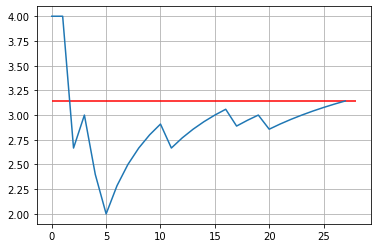

In [22]:
%matplotlib inline
plt.grid()
plt.hlines(np.pi, 0 , len(pi_list), color='red')
plt.plot(pi_list)

In [33]:
pi_classical, pi_list_classical = calculate_pi(3,'classical')

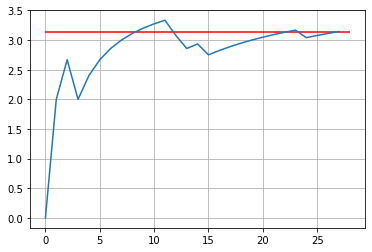

In [34]:
plt.grid()
plt.hlines(np.pi, 0, len(pi_list_classical), color='red' )
plt.plot(pi_list_classical)

In [35]:
pi_qasm_sim , pi_list_qasm_sim = calculate_pi(3, 'quantum')

least busy backend:  qasm_simulator
Job Status: job has successfully run


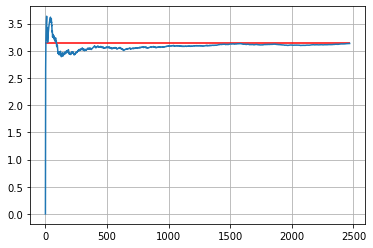

In [36]:
plt.grid()
plt.hlines(np.pi, 0, len(pi_list_qasm_sim), color='red' )
plt.plot(pi_list_qasm_sim)